# Bootstrapping Method for Correlation Hypothesis Test

In [1]:
import numpy as np
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style("whitegrid")  

## The data

Let's calculate the correlation coefficient for the same data we used while we compared paired samples.

In [2]:
np.random.seed(12)
grade_before = np.random.normal(85.5, 3, 80)
grade_after  = np.random.normal(86,   4, 80)
grade_after2 = np.random.normal(90,   3, 80)

## Computing the correlation

Let's use the NumPy function `corrcoef` for calculating the correlation.

In [3]:
np.corrcoef(grade_before, grade_after)

array([[1.        , 0.07143399],
       [0.07143399, 1.        ]])

The result is a symmetric matrix. In this case, we are interested in the non-diagonal values.

In [4]:
np.corrcoef(grade_before, grade_after)[0][1]

0.0714339948718494

In [5]:
# The correlation matrix is symmetric.
np.corrcoef(grade_before, grade_after)[1][0]

0.07143399487184939

In [6]:
# The statistic
stat_r = np.corrcoef(grade_before, grade_after)[0][1]
stat_r

0.0714339948718494

## Calculating the Correlation Sample Distribution using Bootstrap Method

We draw many bootstrapped samples (`num_samples = 10000` for instance), of size `sample_size`, with replacement, from a population consisting of the original data. We draw samples pairwise, meaning that when we sample a value from `grade_before`, we also draw the corresponding value of `grade_after`. With them we calculate the correlation.

`corrSampleDistribution` is the function for generating paired samples WITH replacement and calculate the correlation sample distribution.

In [7]:
def corrSampleDistribution(sample_before, sample_after, num_samples=10000, sample_size=100):
    '''
    It returns a list with the correlation sample distribution.
    '''
    corrSD = np.full((num_samples), 0.)
    x = np.array(sample_before)
    y = np.array(sample_after)
    idx = np.array(range(len(sample_after)))
    for k in range(num_samples):
        index = np.random.choice(idx, replace=True, size=sample_size)
        corrSD[k] = np.corrcoef(x[index], y[index])[0][1]
    return(corrSD)  

In [8]:
r_sample_distribution = corrSampleDistribution(grade_before, grade_after, sample_size=50)

Let's create a function for plot the sample distribution.

In [9]:
def plotSampleDistribution(sample_distribution):
    '''
    It plots the sample distribution
    '''
    sns.kdeplot(sample_distribution, shade=True, color='orangered').set(title='Sample Distribution')

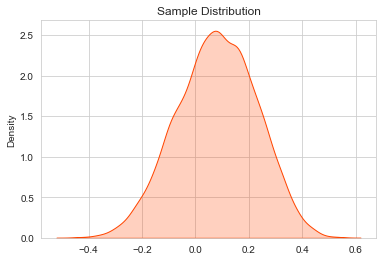

In [10]:
plotSampleDistribution(r_sample_distribution)

### Bootstrap Method 1: calculating the pValue

Let's use the `getpValue` function we already know.

In [11]:
def getpValue(sample_distribution, obs_value, alternative='two-sided'):
    '''
    It returns the p-value.
    sample_distribution: the sample distribution
    obs_value:           observed value 
    alpha:               significance level
    alternative:         one of the three values: 'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        if obs_value < np.mean(sample_distribution): 
            p_val = 2*ecdf(obs_value)
        else: 
            p_val = 2*(1-ecdf(obs_value)) 
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

Let's create a new function: `hyp_test_corr` to calculate the correlation coefficient's bootstrap hypothesis test.

In [12]:
def hyp_test_corr(sample_distribution, sample_value, alpha=0.05):
    '''
    It calculates the bootstrapping hypothesis test for correlation.
    sampl_value:        statistic calculated from the sample
    sampl_distribution: sample distribution calculated using bootstrap from the sample
    alpha:              significance level
    '''
    print('--- Correlation Hypothesis Test with Bootstrap ---')
    print('    Ho: r == 0')
    print('    Ha: r != 0')
    # computing the sample distribution under Ho
    sample_distribution_Ho = sample_distribution - np.mean(sample_distribution)
    # plotting the sample distribution
    sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', shade=True, alpha=0.4)
    plt.title('Bootstrap Sampling Distribution for Correlation')
    # plotting the statistic
    plt.axvline(x=sample_value, ymin=0, ymax= 0.03, color='black', linewidth=6)
    # calculating the p-value
    p_val = getpValue(sample_distribution_Ho, sample_value)
    # plotting the critical regions
    cv1 = np.round(np.percentile(sample_distribution_Ho, (alpha/2)*100),2)       # left critical value  
    cv2 = np.round(np.percentile(sample_distribution_Ho, 100-(alpha/2)*100),2)   # right critical value  
    plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    print('    r = %.4f    p-value = %.4f' %(sample_value, p_val))

--- Correlation Hypothesis Test with Bootstrap ---
    Ho: r == 0
    Ha: r != 0
    r = 0.0714    p-value = 0.6636


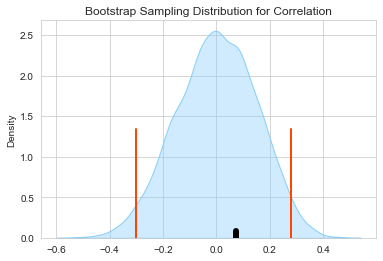

In [13]:
hyp_test_corr(r_sample_distribution, stat_r)

p-value > 0.05 We have no reason to reject the null hypothesis!

There is no correlation between the two variables: `grade_before` and `grade_after`

### Bootstrap Method 2: Using percentiles

This method is equivalent to the previous one. We will calculate a confidence interval over the correlation sample distribution. If the interval contains 0, there is no reason for rejecting Ho; else, you can assure there is a significant correlation between the two paired variables.

In [14]:
def percentile_hyp_test_corr(sample_distribution, sampl_value, alpha=0.05):
    '''
    It calculates the percentile bootstrapping hypothesis test for correlation.
    sampl_value:        observed value calculated from the sample
    sampl_distribution: sample distribution calculated from the sample
    alpha:              significance level
    alternative:        one of the three values: 'two-sided', 'smaller', and 'larger'
    '''
    print('--- Percentile Bootstrap Correlation Hypothesis Test ---')
    print('    Ho: r == 0')
    print('    Ha: r != 0')
    # plotting the sample distribution
    sns.kdeplot(x=sample_distribution, color='lightskyblue', shade=True, alpha=0.4)
    plt.title('Percentile Bootstrap Sampling Distribution for Correlation')
    # plotting the 0 value
    plt.axvline(x=0, ymin=0, ymax= 0.03, color='darkred', linewidth=6)
    # plotting the confidence interval
    cv1 = np.round(np.percentile(sample_distribution, (alpha/2)*100),2)       # left critical value  
    cv2 = np.round(np.percentile(sample_distribution, 100-(alpha/2)*100),2)   # right critical value  
    plt.axvline(x = cv1, ymin=0, ymax=0.5, color='darkred', linewidth=2)
    plt.axvline(x = cv2, ymin=0, ymax=0.5, color='darkred', linewidth=2)
    c = 100 - alpha * 100
    print('    r = %.4f \t %i%% CI = (%.4f, %.4f)' %(sampl_value, c, cv1, cv2))

--- Percentile Bootstrap Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.0714 	 95% CI = (-0.2200, 0.3600)


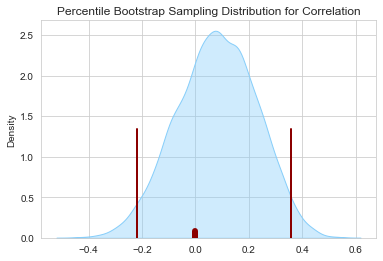

In [15]:
percentile_hyp_test_corr(r_sample_distribution, stat_r)

The confidence interval includes the 0 value. We have no reason to reject the null hypothesis!

There is no correlation between the two variables: `grade_before` and `grade_after`

### Summarising

To calculate the correlation bootstrap hypothesis test between `x` and `y`, we need to follow the steps:
- Calculate the correlation between `x` and `y`
- Calculate the correlation sample distribution
- Calculate the hypothesis test using the `pvalue` or the `percentile` method. 

Remember, both methods are the same. We are just providing two different options.

Let us define a simple class.

In [16]:
class bootCorr():
    '''
    It calculates the correlation hypothesis test using bootstrapping method.
    '''

    def __init__(self, sample1, sample2, num_samples=10000, sample_size=100):
        '''
        '''
        # The correlation value between sample1 and sample2
        self.stat_r = np.corrcoef(sample1,sample2)[0][1]
        # Calculating the bootstrap sample distribution
        self.r_sample_distribution = corrSampleDistribution(sample1, sample2, num_samples=num_samples, sample_size=sample_size)


    def corrSampleDistribution(self, sample_before, sample_after, num_samples=10000, sample_size=100):
        '''
        It returns a list with the correlation sample distribution.
        '''
        corrSD = np.full((num_samples), 0.)
        x = np.array(sample_before)
        y = np.array(sample_after)
        idx = np.array(range(len(sample_after)))
        for k in range(num_samples):
            index = np.random.choice(idx, replace=True, size=sample_size)
            corrSD[k] = np.corrcoef(x[index], y[index])[0][1]
        return(corrSD) 


    def getpValue(self, sample_distribution, obs_value, alternative='two-sided'):
        '''
        sample_distribution:                  the sample distribution
        obs_value:                            observed value 
        alpha:                                significance level
        alternative: one of the three values: 'two-sided', 'smaller', or 'larger'    
        '''
        ecdf = ECDF(sample_distribution) 
        if alternative=='two-sided':
            if obs_value < np.mean(sample_distribution): 
                p_val = 2*ecdf(obs_value)
            else: 
                p_val = 2*(1-ecdf(obs_value)) 
        elif alternative=='smaller':
            p_val = ecdf(obs_value)
        else:
            p_val = 1-ecdf(obs_value)
        return(p_val)    


    def hyp_test_corr(self, alpha=0.05):
        '''
        It calculates the correlation coefficient's bootstrap hypothesis test.
        sampl_value:        statistic calculated from the sample
        sampl_distribution: sample distribution calculated using bootstrap from the sample
        alpha:              significance level
        '''
        print('--- Correlation Hypothesis Test with Bootstrap ---')
        print('    Ho: r == 0')
        print('    Ha: r != 0')
        # computing the sample distribution under Ho
        sample_distribution_Ho = self.r_sample_distribution - np.mean(self.r_sample_distribution)
        # plotting the sample distribution
        sns.kdeplot(x=sample_distribution_Ho, color='lightskyblue', shade=True, alpha=0.4)
        plt.title('Bootstrap Sampling Distribution for Correlation')
        # plotting the statistic
        plt.axvline(x=self.stat_r, ymin=0, ymax= 0.03, color='black', linewidth=6)
        # calculating the p-value
        p_val = getpValue(sample_distribution_Ho, self.stat_r)
        # plotting the critical regions
        cv1 = np.round(np.percentile(sample_distribution_Ho, (alpha/2)*100),2)       # left critical value  
        cv2 = np.round(np.percentile(sample_distribution_Ho, 100-(alpha/2)*100),2)   # right critical value  
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        print('    r = %.4f    p-value = %.4f' %(self.stat_r, p_val))


    def percentile_hyp_test_corr(self, alpha=0.05):
        '''
        sampl_value:        observed value calculated from the sample
        sampl_distribution: sample distribution calculated from the sample
        alpha:              significance level
        alternative:        one of the three values: 'two-sided', 'smaller', and 'larger'
        '''
        print('--- Percentile Bootstrap Correlation Hypothesis Test ---')
        print('    Ho: r == 0')
        print('    Ha: r != 0')
        # plotting the sample distribution
        sns.kdeplot(x=self.r_sample_distribution, color='lightskyblue', shade=True, alpha=0.4)
        plt.title('Percentile Bootstrap Sampling Distribution for Correlation')
        # plotting the 0 value
        plt.axvline(x=0, ymin=0, ymax= 0.03, color='darkred', linewidth=6)
        # plotting the confidence interval
        cv1 = np.round(np.percentile(self.r_sample_distribution, (alpha/2)*100),2)       # left critical value  
        cv2 = np.round(np.percentile(self.r_sample_distribution, 100-(alpha/2)*100),2)   # right critical value  
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='darkred', linewidth=2)
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='darkred', linewidth=2)
        c = 100 - alpha * 100
        print('    r = %.4f    %i%% CI = (%.4f, %.4f)' %(self.stat_r, c, cv1, cv2))

        
    def corr(self, option='pvalue', alpha=0.05):
        '''
        It allows you to calculate one of the the correlation hypothesis tests using bootstrap: 
        "pvalue" or "percentile"
        '''    
        if option == 'pvalue':
            self.hyp_test_corr(alpha=alpha)
        elif option == 'percentile':
            self.percentile_hyp_test_corr(alpha=alpha)    

In [17]:
C = bootCorr(grade_before, grade_after)

--- Correlation Hypothesis Test with Bootstrap ---
    Ho: r == 0
    Ha: r != 0
    r = 0.0714    p-value = 0.5190


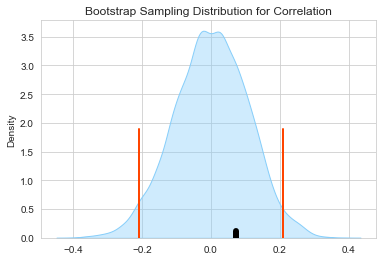

In [18]:
C.corr('pvalue')

p-value > 0.05, there is no reason for rejecting Ho, the correlation is not significant!

--- Percentile Bootstrap Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.0714    95% CI = (-0.1400, 0.2800)


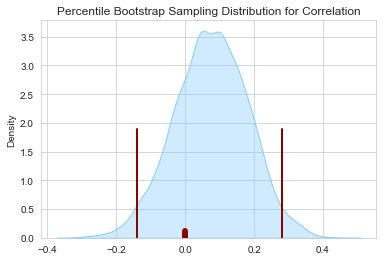

In [19]:
C.corr('percentile')

The confidence interval contains 0, the correlation is not significant!

In [20]:
C2 = bootCorr(grade_before, grade_after2)

--- Correlation Hypothesis Test with Bootstrap ---
    Ho: r == 0
    Ha: r != 0
    r = 0.1077    p-value = 0.3644
--- Percentile Bootstrap Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.1077    99% CI = (-0.2000, 0.3800)


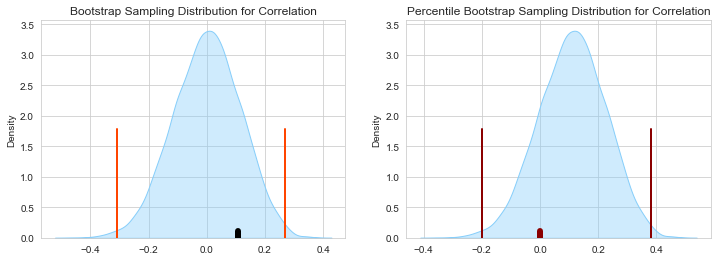

In [21]:
# Analyzing the correlation with alpha=0.01
plt.figure(figsize=(12,4))

plt.subplot(121)
C2.corr('pvalue', alpha=0.01)

plt.subplot(122)
C2.corr('percentile', alpha=0.01)

There is not reason for rejecting Ho, the correlation is not significant!

## Examples

Let's use our previous examples.

In [22]:
df = pd.read_csv('corrExamples.csv')
print(df.shape)
df.head(3)

(50, 6)


,x,y_spc,y_snc,y_wpc,y_wnc,y_nc
0,14.946016,60.934277,-18.311426,15.939970,-5.939970,7.075053
1,12.280831,52.439626,-15.479875,21.534672,-11.534672,9.034883
2,12.554739,52.487695,-15.495898,20.719120,-10.719120,3.187492


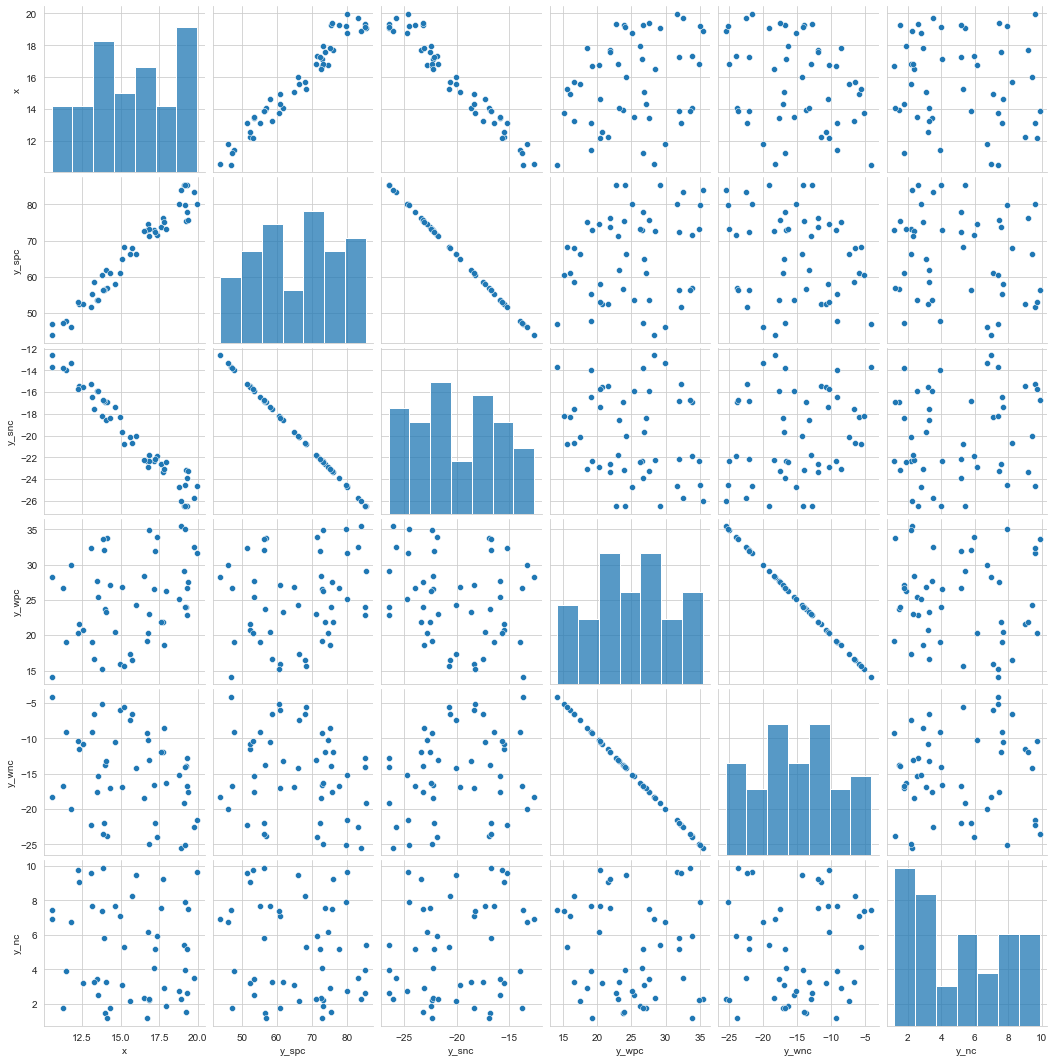

In [23]:
sns.pairplot(df);

### Strong Correlation

In [24]:
# We will generate samples of size 40 (Remember, bootstrap uses a resampling with replacement)
size = 40

In [25]:
# x = df.x and y = df.y_spc (strong positive correlation)
Cs1 = bootCorr(df.x, df.y_spc, sample_size=size)

--- Correlation Hypothesis Test with Bootstrap ---
    Ho: r == 0
    Ha: r != 0
    r = 0.9734    p-value = 0.0000
--- Percentile Bootstrap Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.9734    95% CI = (0.9600, 0.9800)


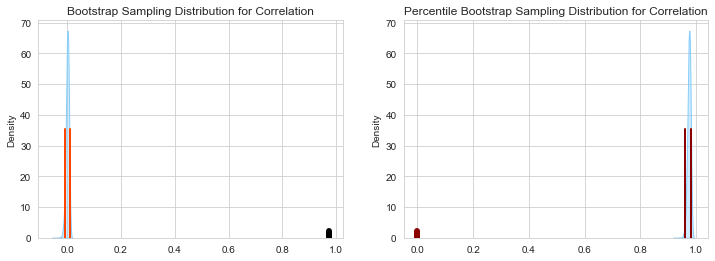

In [26]:
plt.figure(figsize=(12,4))

plt.subplot(121)
Cs1.corr('pvalue', alpha=0.05)

plt.subplot(122)
Cs1.corr('percentile', alpha=0.05)

Without any doubt, there is a strong correlation between df.x and df.y_spc

In [27]:
# x = df.x and y = df.y_snc (strong negative correlation)
Cs2 = bootCorr(df.x, df.y_snc, sample_size=size)

--- Correlation Hypothesis Test with Bootstrap ---
    Ho: r == 0
    Ha: r != 0
    r = -0.9734    p-value = 0.0000
--- Percentile Bootstrap Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = -0.9734    95% CI = (-0.9800, -0.9600)


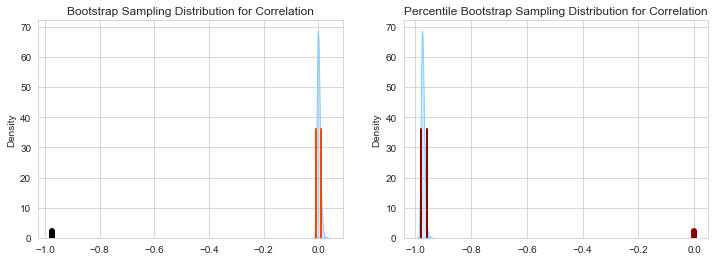

In [28]:
plt.figure(figsize=(12,4))

plt.subplot(121)
Cs2.corr('pvalue', alpha=0.05)

plt.subplot(122)
Cs2.corr('percentile', alpha=0.05)

p-value < 0.05 We reject Ho, the correlation is significant!

The confidence interval does not contains 0, therefore the correlation is significant!

Without any doubt, there is a strong correlation between df.x and df.y_snc

### Weak Correlation

In [29]:
# x = df.x and y = df.y_wpc (weak positive correlation)
Cs3 = bootCorr(df.x, df.y_wpc, sample_size=size)

--- Correlation Hypothesis Test with Bootstrap ---
    Ho: r == 0
    Ha: r != 0
    r = 0.2898    p-value = 0.0230
--- Percentile Bootstrap Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = 0.2898    95% CI = (0.0000, 0.5400)


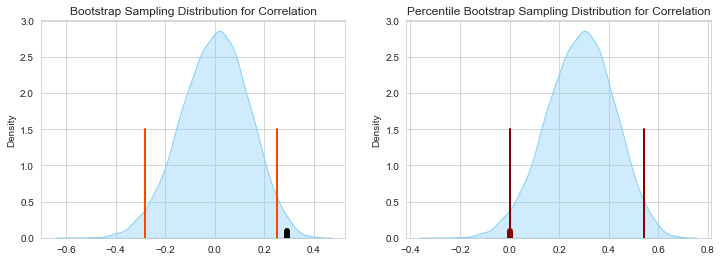

In [30]:
plt.figure(figsize=(12,4))

plt.subplot(121)
Cs3.corr('pvalue', alpha=0.05)

plt.subplot(122)
Cs3.corr('percentile', alpha=0.05)

0.0208 < 0.05 We reject Ho, but notice 0.0208 is pretty close to 0.05 and the correlation value is not high (r=0.2898)

Besides, the confidence interval is barely including 0.

We could say there is a weak correlation between df.x and df.y_wpc

In [31]:
# x = df.x and y = df.y_wnc (weak negative correlation)
Cs4 = bootCorr(df.x, df.y_wnc, sample_size=size)

--- Correlation Hypothesis Test with Bootstrap ---
    Ho: r == 0
    Ha: r != 0
    r = -0.2898    p-value = 0.0220
--- Percentile Bootstrap Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = -0.2898    95% CI = (-0.5400, 0.0000)


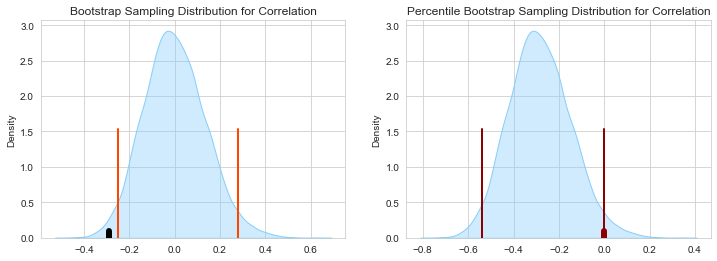

In [32]:
plt.figure(figsize=(12,4))

plt.subplot(121)
Cs4.corr('pvalue', alpha=0.05)

plt.subplot(122)
Cs4.corr('percentile', alpha=0.05)

0.0202 < 0.05 We reject Ho, but notice 0.0202 is pretty close to 0.05 and the correlation value is not high (r-=0.2898)

The confidence interval of the percentile method does not include 0.

One method agrees with a linear relationship, and the other does not. We could say there is a weak correlation, if any, between df.x and df.y_wnc

### No Correlation

In [33]:
# x = df.x and y = df.y_nc (no correlation)
Cs5 = bootCorr(df.x, df.y_nc, sample_size=size)

--- Correlation Hypothesis Test with Bootstrap ---
    Ho: r == 0
    Ha: r != 0
    r = -0.1384    p-value = 0.3796
--- Percentile Bootstrap Correlation Hypothesis Test ---
    Ho: r == 0
    Ha: r != 0
    r = -0.1384    99% CI = (-0.5200, 0.2600)


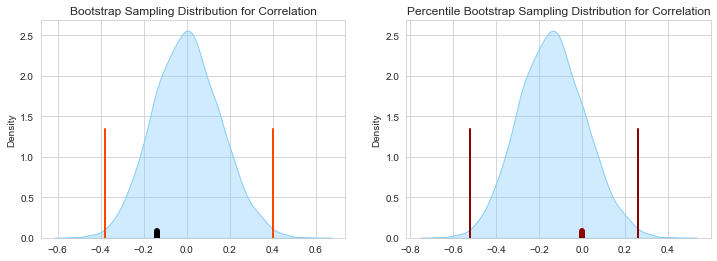

In [34]:
plt.figure(figsize=(12,4))

plt.subplot(121)
Cs5.corr('pvalue', alpha=0.01)

plt.subplot(122)
Cs5.corr('percentile', alpha=0.01)

0.3758 > 0.05 We have no reasons for rejecting Ho; there is no correlation!

The confidence interval of the percentile method does not include 0; there is no correlation!

Reference:
- VanderPlas, J. (2017) Python Data Science Handbook: Essential Tools for Working with Data. USA: O’Reilly Media, Inc. chapter 4.